# ukis-metrics
A brief example of how ukis-metrics can be used.
## Preparation
Install [ukis-metrics](https://github.com/dlr-eoc/ukis-metrics) to your local environment: 

`pip install ukis-metrics`

[Link to PyPI](https://pypi.org/project/ukis-metrics/)

In [1]:
## imports
import numpy as np
import ukis_metrics.seg_metrics as segm
from ukis_pysat.raster import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score, cohen_kappa_score
import time

In [2]:
# ndarray containing the reference data, e.g. the water mask
shape = (256, 256, 1)
y_true = np.ones(shape)
# ndarray containing the model predicions, e.g.
y_pred = np.ones(shape)
# get tp, fp, tn, fn an n_valid_pixel
tpfptnfn = segm.tpfptnfn(y_true, y_pred, None)
metrics = segm.segmentation_metrics(tpfptnfn)

In [3]:
metrics

{'iou': 1.0,
 'recall': 1.0,
 'precision': 1.0,
 'acc': 1.0,
 'F1': 1.0,
 'kappa': 0.0}

# Further examples
Generate a reference water mask and the corresponding prediction and compute the scores:

In [4]:
shape=(10000, 10000)
y_true = np.random.randint(0,2, shape)
y_pred = np.random.randint(0,2, shape)
valid_mask = np.ones(y_pred.shape)

Plot the data:

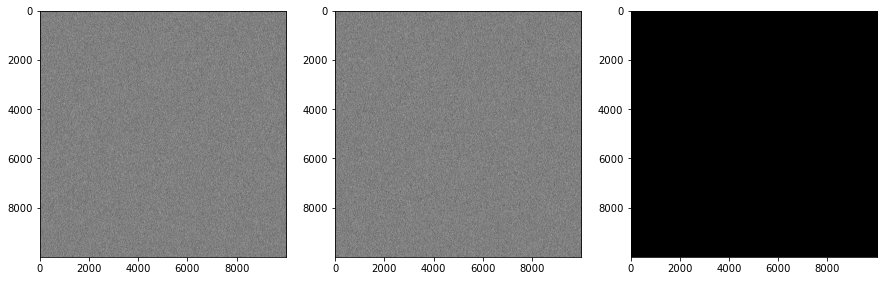

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
cmap = "gray"
axs[0].imshow(y_true, cmap=cmap)
axs[1].imshow(y_pred, cmap=cmap)
axs[2].imshow(valid_mask, cmap=cmap)

# Compare computation time to scikit-learn
## Accuracy
### ukis-metrics

In [30]:
tic = time.perf_counter()
tpfptnfn_val = segm.tpfptnfn(y_true, y_pred, valid_mask)
acc = segm._accuracy(tpfptnfn_val["tp"], tpfptnfn_val["fp"], tpfptnfn_val["tn"], tpfptnfn_val["fn"])
d_own = time.perf_counter() - tic
print(f"Accuracy: {acc}\t\tTime: {d_own}")

Accuracy: 0.50003107		Time: 2.0238373890169896


### sklearn
We need to remove the invalid pixels form the array before they are handed over to sklearn

In [31]:
tic = time.perf_counter()
y_true_sk = y_true[valid_mask == 1]
y_pred_sk = y_pred[valid_mask == 1]
acc = accuracy_score(y_true_sk.flatten(), y_pred_sk.flatten())
d_sk = time.perf_counter() - tic
print(f"Accuracy: {acc}\t\tTime: {d_sk}")

Accuracy: 0.50003107		Time: 10.75869138300186


## IoU
### ukis-metrics

In [32]:
tic = time.perf_counter()
tpfptnfn_val = segm.tpfptnfn(y_true, y_pred, valid_mask)
iou = segm._intersection_over_union(tpfptnfn_val["tp"], tpfptnfn_val["fp"], tpfptnfn_val["tn"], tpfptnfn_val["fn"])
d_own = time.perf_counter() - tic
print(f"IoU: {acc}\t\tTime: {d_own}")

IoU: 0.50003107		Time: 1.968346235982608


### sklearn

In [33]:

tic = time.perf_counter()
y_true_sk = y_true[valid_mask == 1]
y_pred_sk = y_pred[valid_mask == 1]
iou = jaccard_score(y_true_sk.flatten(), y_pred_sk.flatten())
d_sk = time.perf_counter() - tic
print(f"IoU: {acc}\t\tTime: {d_sk}")


IoU: 0.50003107		Time: 41.65383465102059


# Using the valid pixel mask
We can use the valid pixel mask to indicate pixels that should not be considered when computing the metrics for whatever reason (clouds, border pixels, ...). We simply pass the mask to `segm.tpfptnfn(y_true, y_pred, valid_mask)`. If we don't provide a mask (i.e. we pass `Ǹone`), `segm.tpfptnfn()` creates it's own valid mask where all pixels are marked as valid.

## Example

In [37]:
x = 250
y = 250
size = 1024
y_true_window = y_true[x:x+size, y:y+size]
y_pred_window = y_pred[x:x+size, y:y+size]
valid_mask_window = np.ones(y_true_window.shape)

Accuracy: 0.50003107


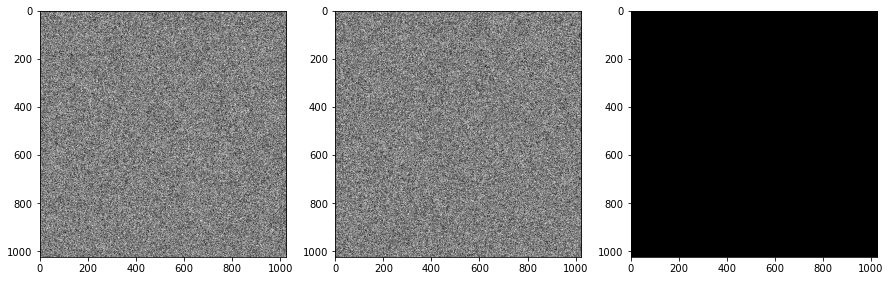

In [40]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs[0].imshow(y_true_window[:,:], cmap=cmap)
axs[1].imshow(y_pred_window[:,:], cmap=cmap)
axs[2].imshow(valid_mask_window[:,:], cmap=cmap)
# compute accuracy
tpfptnfn = segm.tpfptnfn(y_true_window, y_pred_window, valid_mask_window)
acc = segm._accuracy(tpfptnfn_val["tp"], tpfptnfn_val["fp"], tpfptnfn_val["tn"], tpfptnfn_val["fn"])
print(f'Accuracy: {acc}')

Assuming there are clouds in the lower left corner: we can ignore it by passing the valid mask:

In [43]:
valid_mask_window[650:,:400] = 0

Accuracy: 0.50003107


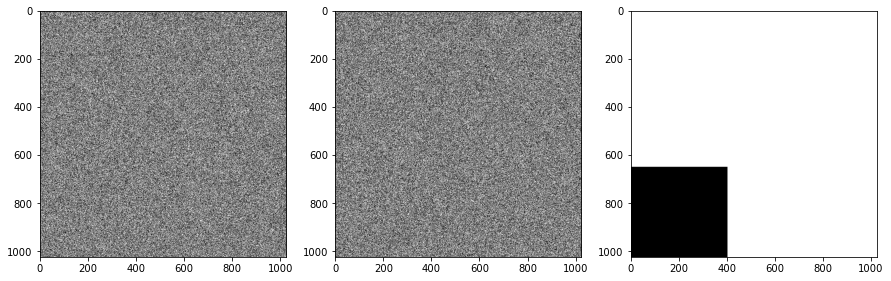

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs[0].imshow(y_true_window[:,:], cmap=cmap)
axs[1].imshow(y_pred_window[:,:], cmap=cmap)
axs[2].imshow(valid_mask_window[:,:],cmap=cmap)
# compute accuracy
tpfptnfn = segm.tpfptnfn(y_true_window, y_pred_window, valid_mask_window)
acc = segm._accuracy(tpfptnfn_val["tp"], tpfptnfn_val["fp"], tpfptnfn_val["tn"], tpfptnfn_val["fn"])
print(f'Accuracy: {acc}')

# Extending to multi class problems
This should work easily: we can extend the base one class metrics by passing one array per class.

In [46]:
size = 1024
shape = (size, size)
y_true_mcls = np.zeros(shape)
y_true_mcls[460:753,210:340] = 1
y_true_mcls[260:600, 550:800] = 2

y_pred_mcls = np.zeros(shape)
y_pred_mcls[444:711, 190:400] = 1
y_pred_mcls[300:550, 400:750] = 2

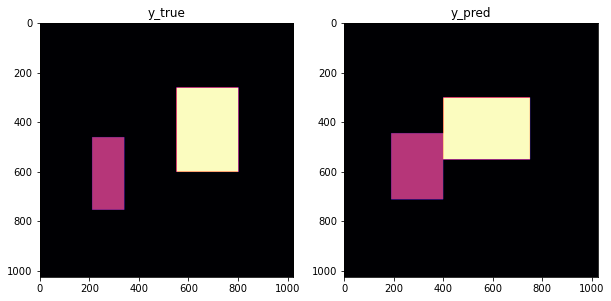

In [47]:
# plot
cmap='magma'
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].imshow(y_true_mcls[:,:], cmap=cmap)
axs[0].set_title("y_true")
axs[1].imshow(y_pred_mcls[:,:], cmap=cmap)
axs[1].set_title("y_pred")


# get iou for the classes
# seperate class arrays
y_true_c1 = np.where(y_true_mcls == 1, 1, 0)
y_true_c2 = np.where(y_true_mcls == 2, 1, 0)

y_pred_c1 = np.where(y_pred_mcls == 1, 1, 0)
y_pred_c2 = np.where(y_pred_mcls == 2, 1, 0)

In [48]:
# compute metrics for each class
# class 1
tic = time.perf_counter()
tpfptnfn = segm.tpfptnfn(y_true_c1, y_pred_c1, None)
iou1 = segm._intersection_over_union(tpfptnfn["tp"], tpfptnfn["fp"], tpfptnfn["fn"], tpfptnfn["tn"])
tpfptnfn = segm.tpfptnfn(y_true_c2, y_pred_c2, None)
iou2 = segm._intersection_over_union(tpfptnfn["tp"], tpfptnfn["fp"], tpfptnfn["fn"], tpfptnfn["tn"])
miou = (iou1 + iou2) / 2 
print('time: ', np.round(time.perf_counter() - tic, decimals=4))
print(f'IoU class 1: {iou1}')
print(f'IoU class 2: {iou2}')
print(f'mIoU: {miou}')

time:  0.0568
IoU class 1: 0.5303104176824314
IoU class 2: 0.40816326530612246
mIoU: 0.4692368414942769


In [49]:
# sklearn
tic = time.perf_counter()
iou = jaccard_score([y_true_c1.flatten(), y_true_c2.flatten()], [y_pred_c1.flatten(), y_pred_c2.flatten()], average="samples")
print('time: ', np.round(time.perf_counter() - tic, decimals=4))
print(f'mIoU: {iou}')

time:  0.8184
mIoU: 0.4692368414942769
